In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv("card_cust.csv")
df.head(2)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,10001,40.900749,0.818182,95.4,0.0,95.4,0.000000,0.166667,0.0,0.083333,0.00,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0
1,10002,3202.467416,0.909091,0.0,0.0,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0


In [3]:
df.isna().sum()

CUST_ID                              0
BALANCE                              0
BALANCE_FREQUENCY                    0
PURCHASES                            0
ONEOFF_PURCHASES                     0
INSTALLMENTS_PURCHASES               0
CASH_ADVANCE                         0
PURCHASES_FREQUENCY                  0
ONEOFF_PURCHASES_FREQUENCY           0
PURCHASES_INSTALLMENTS_FREQUENCY     0
CASH_ADVANCE_FREQUENCY               0
CASH_ADVANCE_TRX                     0
PURCHASES_TRX                        0
CREDIT_LIMIT                         0
PAYMENTS                             0
MINIMUM_PAYMENTS                    74
PRC_FULL_PAYMENT                     0
TENURE                               0
dtype: int64

In [4]:
df["MINIMUM_PAYMENTS"] = df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].mean())

In [5]:
df.isna().sum().sum()

0

In [6]:
df_base = df.copy()

### Q1.

In [7]:
df_q1 = df_base[["TENURE", "BALANCE", "CREDIT_LIMIT"]].copy()
df_q1.head(2)

,TENURE,BALANCE,CREDIT_LIMIT
0,12.0,40.900749,1000.0
1,12.0,3202.467416,7000.0


In [8]:
df_q1_sub = df_q1.loc[df_q1["TENURE"] == 12, ]
df_q1_sub[["BALANCE", "CREDIT_LIMIT"]].corr()

,BALANCE,CREDIT_LIMIT
BALANCE,1.000000,0.460833
CREDIT_LIMIT,0.460833,1.000000


In [9]:
df_q1_corr = df_q1.groupby("TENURE")[["BALANCE", "CREDIT_LIMIT"]].corr()
df_q1_corr.head()

BALANCE  CREDIT_LIMIT
TENURE                                     
6.0    BALANCE       1.000000      0.868056
       CREDIT_LIMIT  0.868056      1.000000
7.0    BALANCE       1.000000      0.948405
       CREDIT_LIMIT  0.948405      1.000000
8.0    BALANCE       1.000000      0.820696

In [10]:
# df_q1_corr.reset_index()
df_q1_corr.xs("BALANCE", level = 1)["CREDIT_LIMIT"].round(2).max()

0.95

### Q2.

In [11]:
df_q2 = df_base.drop(columns = "CUST_ID")

In [12]:
df_q2.head(1)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.4,0.0,95.4,0.0,0.166667,0.0,0.083333,0.0,0.0,2.0,1000.0,201.802084,139.509787,0.0,12.0


In [13]:
arr_q2_nor = StandardScaler().fit_transform(df_q2)

In [14]:
arr_q2_nor[:1, ]

array([[-0.84876759, -0.41987944, -0.4419358 , -0.3740477 , -0.39530091,
        -0.48235389, -0.87270064, -0.80432139, -0.71961989, -0.68470093,
        -0.45791753, -0.56411617, -1.16166861, -0.55739615, -0.44372465,
        -0.46554357,  0.28242902]])

In [ ]:
ls_k = list(range(2, 6))

ls_sil = []
for k in ls_k:
    model_kmeans = KMeans(n_clusters = k, random_state = 1234)
    model_kmeans.fit(arr_q2_nor)
    
    val_sil = silhouette_score(arr_q2_nor, labels = model_kmeans.labels_)
    ls_sil = ls_sil + [val_sil]

<AxesSubplot:>

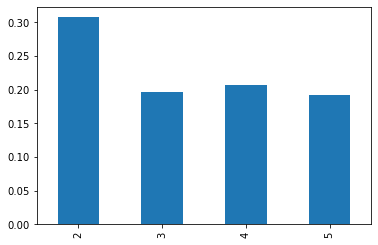

In [16]:
ser_s = pd.Series(ls_sil, index = ls_k)
ser_s.plot.bar()

In [17]:
best_k = ser_s.idxmax()
best_k

2

In [ ]:
model_kmeans_best = KMeans(n_clusters = best_k, random_state = 1234)
model_kmeans_best.fit(arr_q2_nor)

In [20]:
df_q2["cluster"] = model_kmeans_best.labels_

In [22]:
df_q2.groupby("cluster")["ONEOFF_PURCHASES"].mean().round(2)

cluster
0     340.23
1    3946.19
Name: ONEOFF_PURCHASES, dtype: float64

### Q3.

In [27]:
df_train = df_base.loc[(df_base["CUST_ID"] % 4) != 0, ]
df_test  = df_base.loc[(df_base["CUST_ID"] % 4) == 0, ]
len(df_train), len(df_test)

(752, 248)

In [28]:
df_train.shape

(752, 18)

In [30]:
model_dt = DecisionTreeRegressor(random_state = 1234)
model_dt.fit(X = df_train.drop(columns = ["CUST_ID", "ONEOFF_PURCHASES"]),
             y = df_train["ONEOFF_PURCHASES"])
pred = model_dt.predict(df_test.drop(columns = ["CUST_ID", "ONEOFF_PURCHASES"]))
pred[:4]

array([1500.,    0., 1490.,    0.])

In [31]:
y_t = df_test["ONEOFF_PURCHASES"]
y_p = pred

In [36]:
# y_t - y_p # 오차(E, Error)
# (y_t - y_p) ** 2 # 오차 제곱(SE, Squared Error)
# ((y_t - y_p) ** 2).mean() # 오차 제곱의 평균(MSE, Mean Squared Error)
val_rmse = ((y_t - y_p) ** 2).mean() ** 0.5 # 오차 제곱의 평균의 (양의)제곱근(RMSE)
val_rmse

1039.193967231063

In [37]:
round(val_rmse, 1)

1039.2

In [39]:
from sklearn.metrics import mean_squared_error as mse

In [41]:
round(mse(y_true = y_t, y_pred = y_p) ** 0.5, 1)

1039.2

In [42]:
import sklearn.metrics as sm

In [46]:
[f for f in dir(sm) if f[-5:] == "error"]

In [47]:
[f for f in dir(sm) if f[-5:] == "score"]

['accuracy_score',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision_score',
 'balanced_accuracy_score',
 'calinski_harabasz_score',
 'cohen_kappa_score',
 'completeness_score',
 'consensus_score',
 'd2_absolute_error_score',
 'd2_pinball_score',
 'd2_tweedie_score',
 'davies_bouldin_score',
 'dcg_score',
 'explained_variance_score',
 'f1_score',
 'fbeta_score',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard_score',
 'label_ranking_average_precision_score',
 'mutual_info_score',
 'ndcg_score',
 'normalized_mutual_info_score',
 'precision_score',
 'r2_score',
 'rand_score',
 'recall_score',
 'roc_auc_score',
 'silhouette_score',
 'top_k_accuracy_score',
 'v_measure_score']